# Reinforcement Learning: Frozen Lake

##### The Frozen Lake environment is a game with a 4x4 grid.  Some squares are safe, while others are not.  The player must navigate from a start square to an end square safely.  Every turn, the player chooses a direction to move in the grid.  There is some probability of movement in the chosen direction.  Here, I use a Q-learning algorithm to find an optimal choice of direction for every position in the grid.

## Load packages

In [1]:
import gym ### gym package
import matplotlib.pyplot as plt
import scipy
import numpy as np
import random

env = gym.make('FrozenLake-v0') ### Frozen Lake environment

## Observe the grid.  
##### S=start, G=goal, F=safe, H=not safe
##### The cursor is the current position of the player.

In [332]:
state_0=env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


## Define Helper Functions used in Training

##### If s is the current state and a is the chosen action, Q(s,a) is the expected reward.  We use the Bellman equation to update Q.

In [5]:
### Set initial parameters
def set_parameters(alpha,beta,gamma,epsilon,num_episodes):
    
    ### alpha: learning rate
    ### gamma: reward discount rate
    ### beta: dynamic exploration factor
    ### epsilon: exploration rate
    
    parameters = {}
    
    parameters['alpha'] = alpha
    parameters['gamma'] = gamma
    parameters['beta'] = beta
    parameters['epsilon'] = epsilon
    parameters['num_episodes'] = num_episodes
    
    return parameters

### Choose an action given Q, current state, and exploration rate
def action_choice(Q,state_0,epsilon):
    
    random_action = random.choice([0,1,2,3])
    alg_action = np.argmax(Q[state_0])

    if np.random.binomial(1,epsilon) == 0:
        a = alg_action
    else:
        a = random_action
    
    return a

### Update Q given action choice
def update_Q(Q,a,parameters):
    
    target = (parameters['reward'] + parameters['gamma']*np.max(Q[parameters['state_1'],:]) - Q[parameters['state_0'],a])
    
    return Q[parameters['state_0'],a] + parameters['alpha'] * target

### Performance over most recent 100 episodes
def update_perf(rlist):
    
    if len(rlist) > 100:
        return np.mean(rlist[-100:])

### Update exploration rate given recent performance
def update_epsilon(perf,parameters):
    
    if len(perf) > 2 and perf[-1] < perf[-2]:
        return min(parameters['beta'] * parameters['epsilon'],1)
    elif len(perf) > 2 and perf[-1] > perf[-2]:
        return 1/parameters['beta'] * parameters['epsilon']
    else:
        return parameters['epsilon']
    

## Training function
##### We take the following steps for num_episodes:
##### (1) initialize parameters
##### (2) get initial state
##### (3) With probability epsilon, choose either a random action or the action dictated by Q
##### (4) Take the action, observe the new state and reward
##### (5) Update Q according to Bellman equation
##### (6) Track the total reward
##### (7) Exit loop if end state is reached

In [365]:
def train_model(alpha,beta,gamma,epsilon_0,num_episodes):

    env = gym.make('FrozenLake-v0')    ###Initialize environment
    Q = np.zeros([env.observation_space.n,env.action_space.n])    ###Initialize Q function
    parameters = set_parameters(alpha,beta,gamma,epsilon_0,num_episodes)    ###Initialize parameters

    perf = []    ###Running average performance of last 100 episodes
    epsilons = []    ###Epsilons used in each episode
    rList = []    ###Total reward obtained in each episode


    for i in range(parameters['num_episodes']):
        
        parameters['state_0'] = env.reset()
        r = 0

        for t in range(100):

            ### Choice action
            a = action_choice(Q,parameters['state_0'],parameters['epsilon'])

            ### Perform action
            parameters['state_1'],parameters['reward'],parameters['d'],_ = env.step(a)
            
            ### Update Q
            Q[parameters['state_0'],a] = update_Q(Q,a,parameters)
            
            r += parameters['reward']
            
            ### Update state
            parameters['state_0'] = parameters['state_1']

            ### Restart if game ended
            if parameters['d']==True:
                break

        ### Total reward for current episode
        rList.append(r)

        ### Track performance
        if len(rList) > 100:
            perf.append(update_perf(rList))
            
            
        ### Update epsilon
        parameters['epsilon'] = update_epsilon(perf,parameters)

    return Q,perf

## Hyperparameter Exploration
##### Allow variation is hyperparameters to find an optimum.  As a proxy for performance, we take the average of the last 20 episodes.

In [369]:
env = gym.make('FrozenLake-v0')
env.seed(0)
np.random.seed(123)
hyper_parameters=[(alpha,beta,gamma) for alpha in np.linspace(.8,.9,5) for beta in np.linspace(1.1,1.2,5) for gamma in np.linspace(.8,.95,5)]
leader = 0.0
for i in range(125):
    Q,perf = train_model(hyper_parameters[i][0],hyper_parameters[i][1],hyper_parameters[i][2],.5,2000)
    
    if np.mean(perf[-20:]) > leader:
        leader = np.mean(perf[-20:])
        print("new leader"+str(hyper_parameters[i])+str(leader))

new leader(0.8, 1.1, 0.8)0.0075000000000000015
new leader(0.8, 1.1, 0.8375)0.044500000000000005
new leader(0.8, 1.1, 0.875)0.08950000000000001
new leader(0.8, 1.125, 0.875)0.285
new leader(0.8, 1.125, 0.95)0.7275
new leader(0.8, 1.15, 0.9125)0.7665
new leader(0.8, 1.175, 0.9125)0.7735
new leader(0.8250000000000001, 1.2, 0.9125)0.7820000000000003
new leader(0.8500000000000001, 1.125, 0.95)0.8010000000000002
new leader(0.8500000000000001, 1.15, 0.95)0.8019999999999999
new leader(0.875, 1.175, 0.95)0.8215


## Observe performance over training time

0.7404999999999999


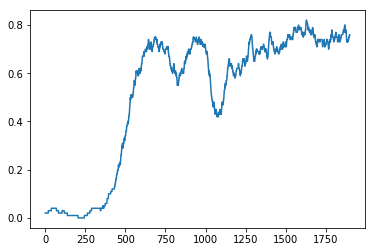

In [370]:
env = gym.make('FrozenLake-v0')
env.seed(0)
np.random.seed(123)
Q,perf = train_model(.875,1.175,.95,.5,2000)
print(np.mean(perf[-20:]))
plt.plot(perf)

## Testing Phase

In [372]:
env.seed(321)
num_episodes = 5000
rlist = []
statelist = []
for j in range(num_episodes):
    done = False
    state_0 = env.reset()
    r = 0
    for i in range(200):
        a = np.argmax(Q[state_0])
        #a = policy[state_0]
        state_0,reward,done,_ = env.step(a)
        r += reward
        if done:
            statelist.append([state_0,i])
            break
        
    rlist.append(r)

print("Average performance:" + str(np.mean(rlist)))


Average performance:0.7468
